In [1]:
import os

import numpy as np
import pandas as pd

from math import ceil

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import zarr
import dask.array as da

from utils.utility_functions import transposeZarr

In [2]:
# Paths and input
out = os.path.join(os.getcwd(), f'output/vae_clustermaps')
if not os.path.exists(out):
    os.makedirs(out)

# Read single-cell sample for VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
filt = main[main['VAE9-VAE20'] != -1].copy()  # removes -1s in VAE9 and VAE20 clusterings

# Set randon seed for reproducible clustermap results
np.random.seed(1)

In [3]:
# Map VAE20 clusters to contexts
VAE20_annot = pd.read_csv(os.path.join(os.getcwd(), 'input/SupTable3.csv'))
cell_context = [VAE20_annot['Call'][VAE20_annot['Cluster'] == i].values[0] for i in filt['VAE20']]
filt.loc[:, 'context'] = [i for i in cell_context]
            
# Map VAE9 clusters to cell states
VAE9_annot = pd.read_csv(os.path.join(os.getcwd(), 'input/SupTable4.csv'))
cell_state = [VAE9_annot['Call'][VAE9_annot['Cluster'] == i].values[0] for i in filt['VAE9']]
filt.loc[:, 'state'] = [i for i in cell_state]

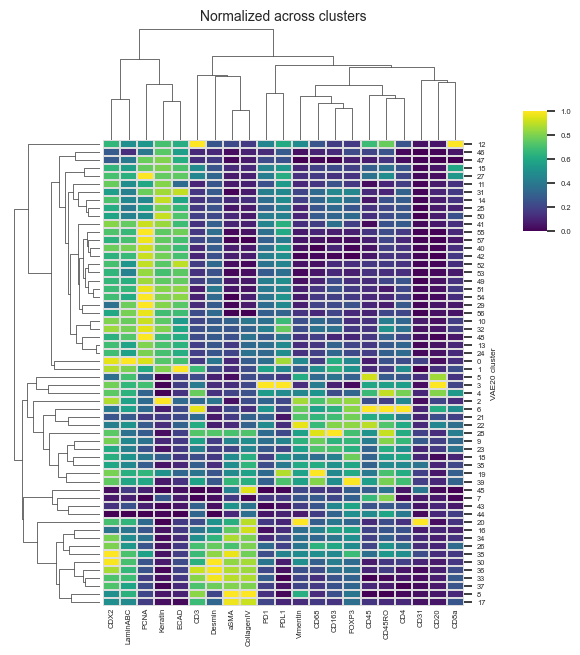

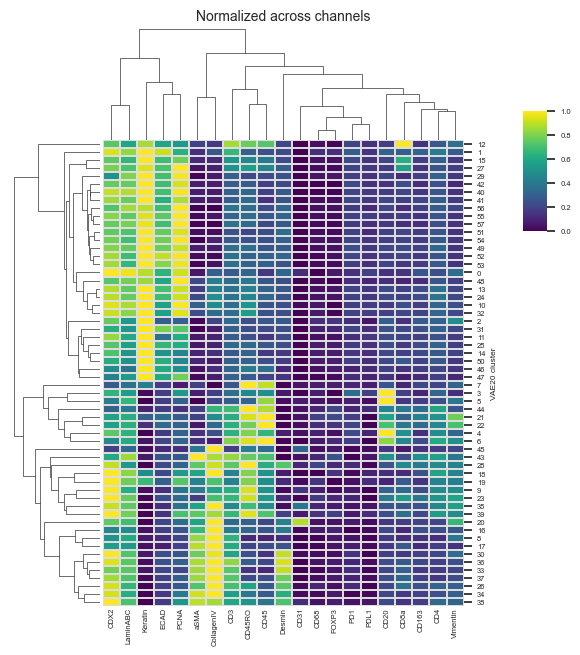

In [4]:
# Compute and plot segmentation-based average intensities for VAE20 clusters
abx_channels = {
    'anti_CD3': 'CD3', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': 'aSMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8a', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

clustermap_input = filt[list(abx_channels.keys()) + ['VAE20']].groupby('VAE20').mean()

sns.set(font_scale=0.5)
for name, axis in zip(['clusters', 'channels'], [1, 0]):

    g = sns.clustermap(
        clustermap_input, cmap='viridis', standard_scale=axis,
        figsize=(2, 30), xticklabels=1, yticklabels=1, linewidth=0.1,
        linecolor='gainsboro', cbar=True
    )
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
    g.ax_heatmap.set_ylabel('VAE20 cluster')
    g.ax_heatmap.set_xticklabels(
        [abx_channels[i.get_text()] for i in g.ax_heatmap.get_xticklabels()], rotation=90
    )
    g.ax_heatmap.get_xaxis().set_tick_params(pad=-5)
    g.ax_cbar.set_position([0.9, 0.65, 0.04, 0.2])
    g.fig.suptitle(f'Normalized across {name}', y=1.02, fontsize=10)
    g.fig.set_size_inches(6.0, 6.0)
    plt.savefig(
        os.path.join(out, f'VAE20_by_segmentation_intensity_norm_{name}.pdf'), bbox_inches='tight'
    )
    plt.show()
    plt.close('all')

Working on VAE9-VAE20 rescale is True...


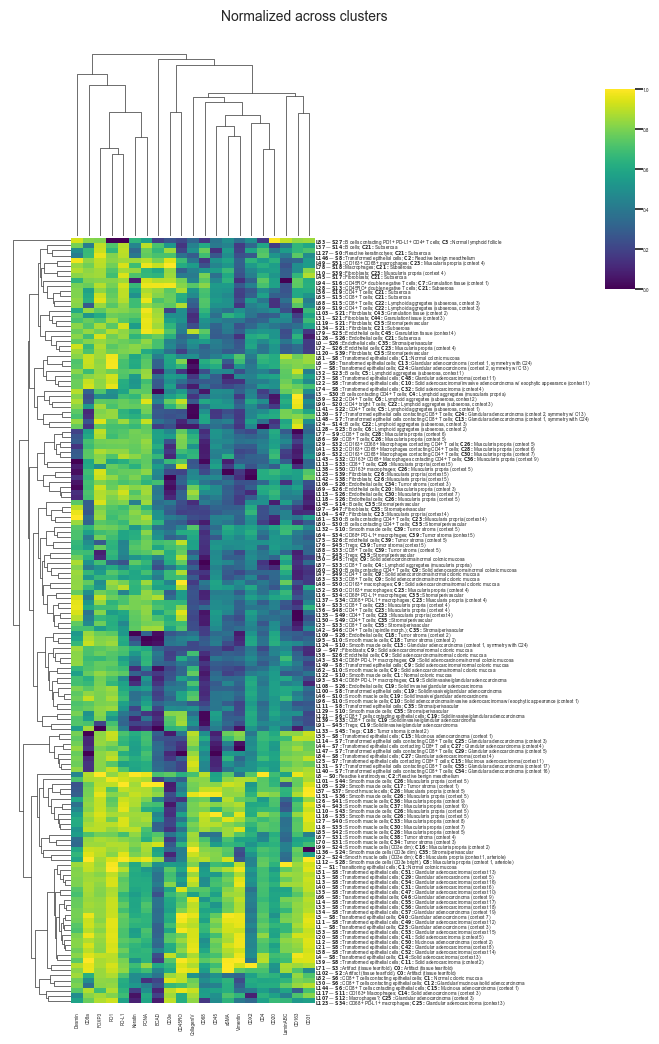

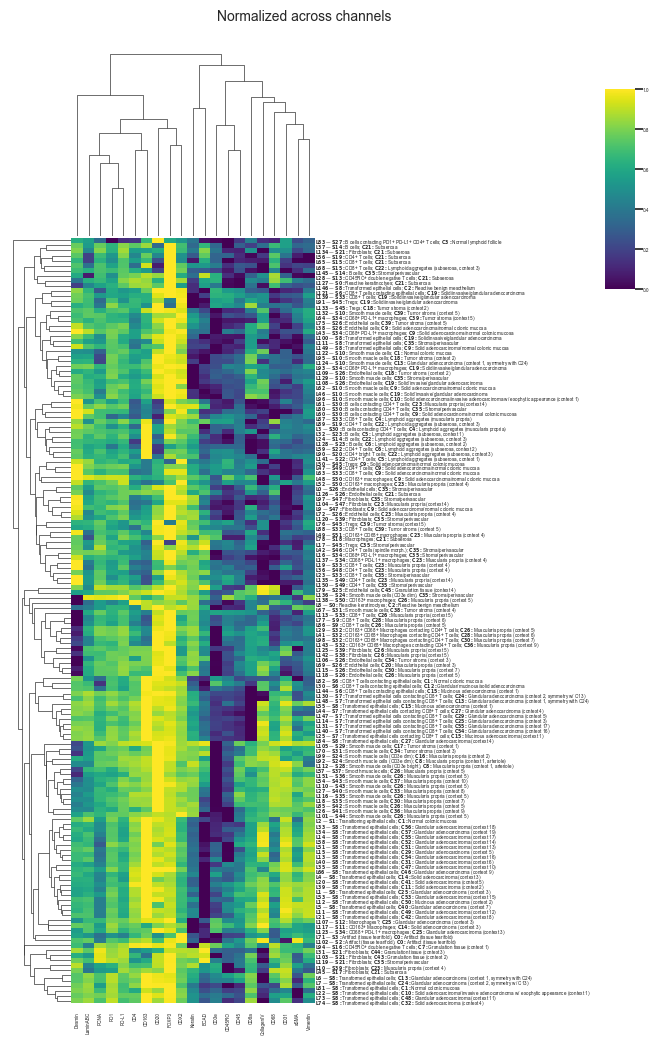


Working on VAE9 rescale is True...


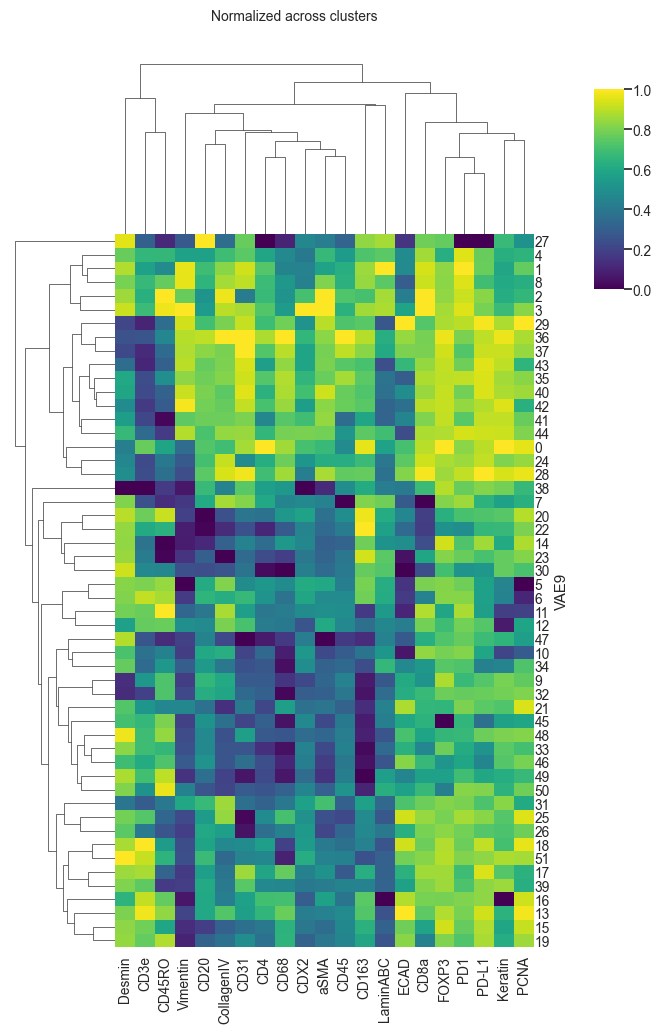

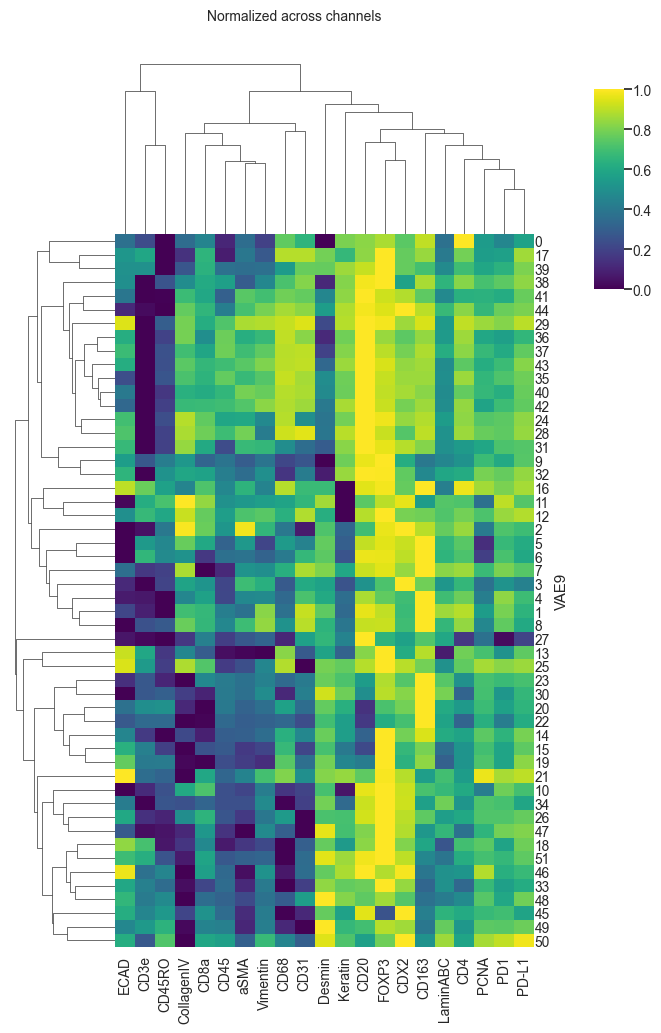


Working on VAE20 rescale is True...


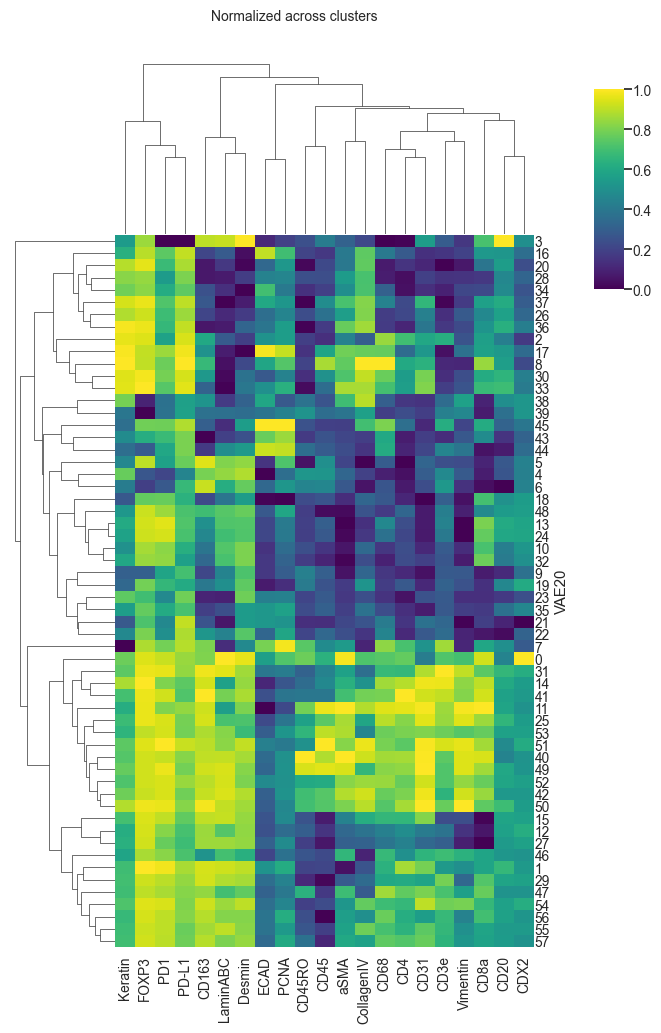

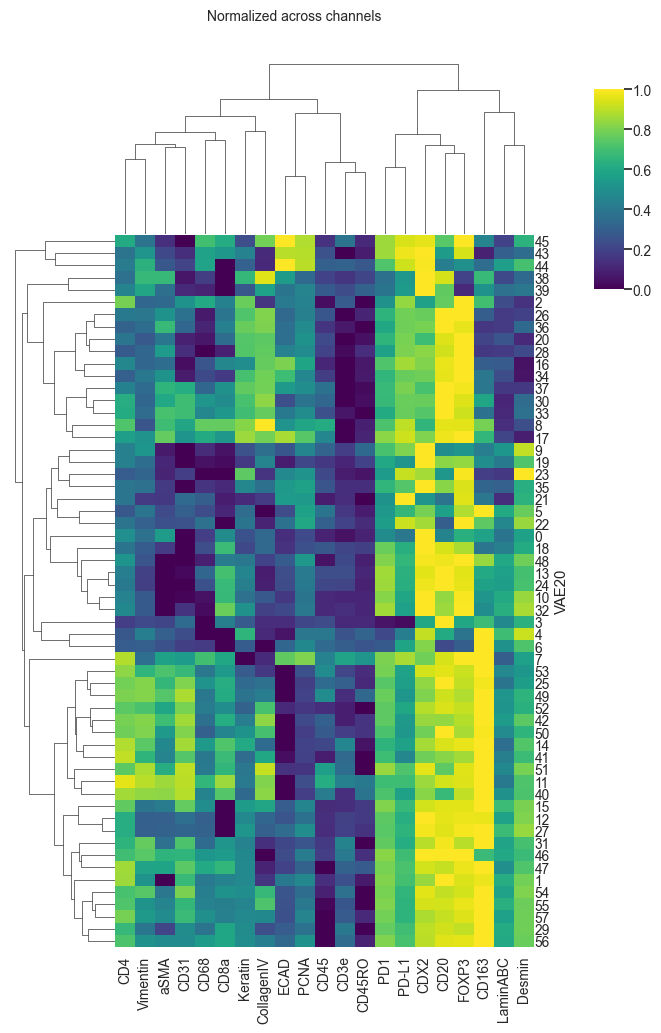


Working on VAE9-VAE20 rescale is False...


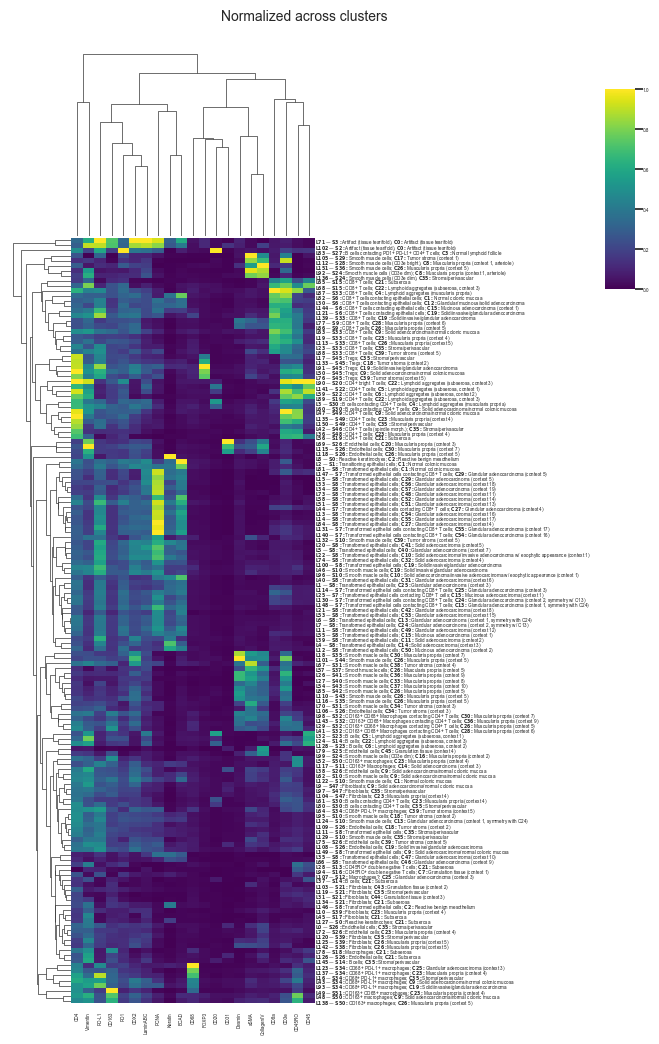

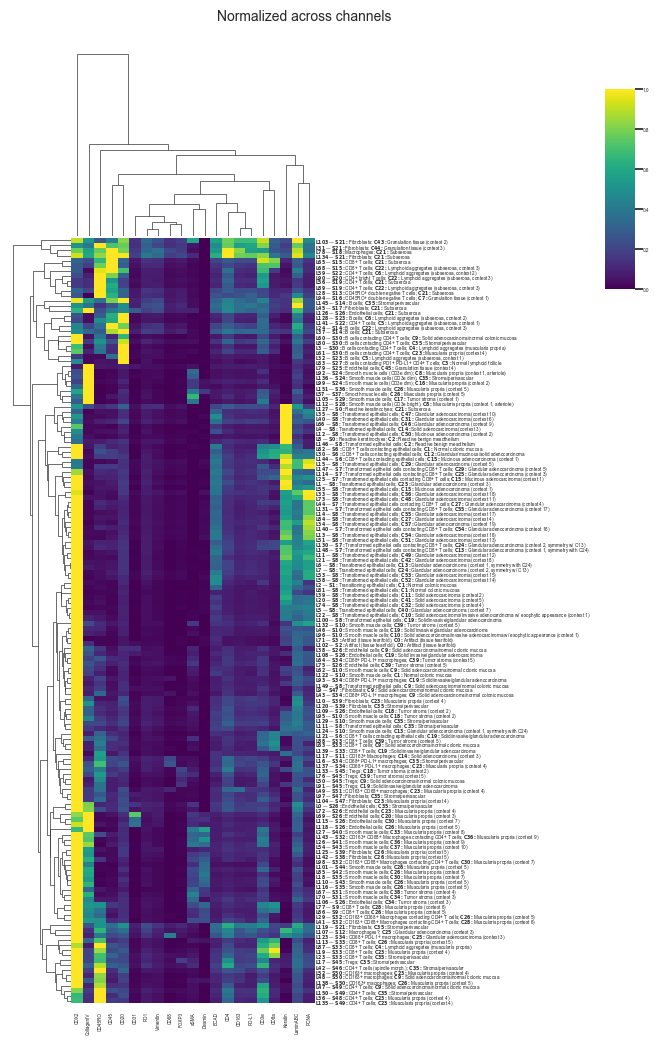


Working on VAE9 rescale is False...


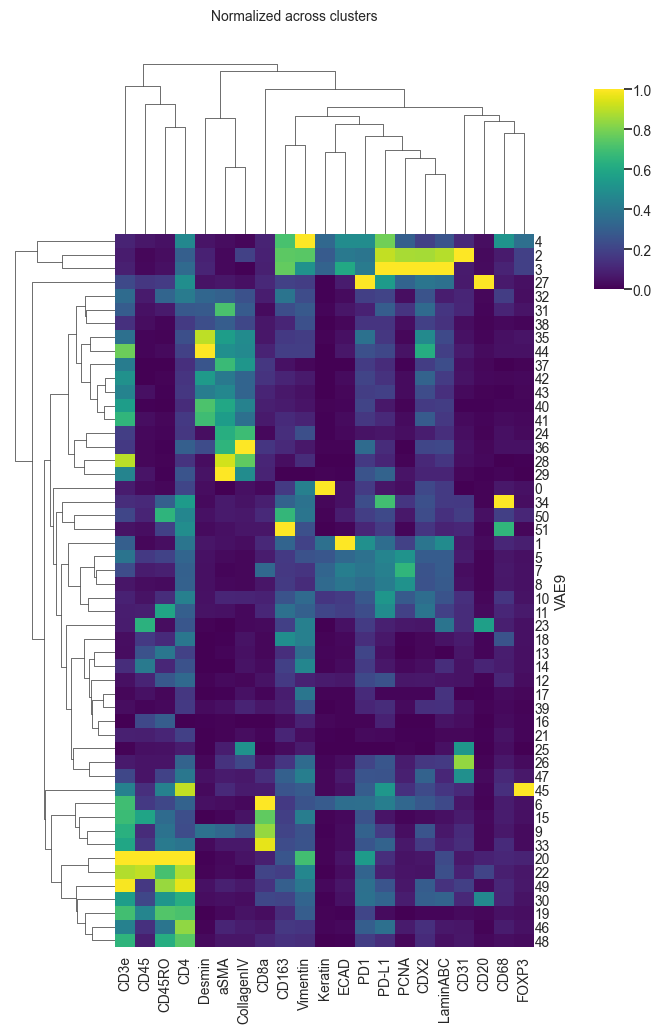

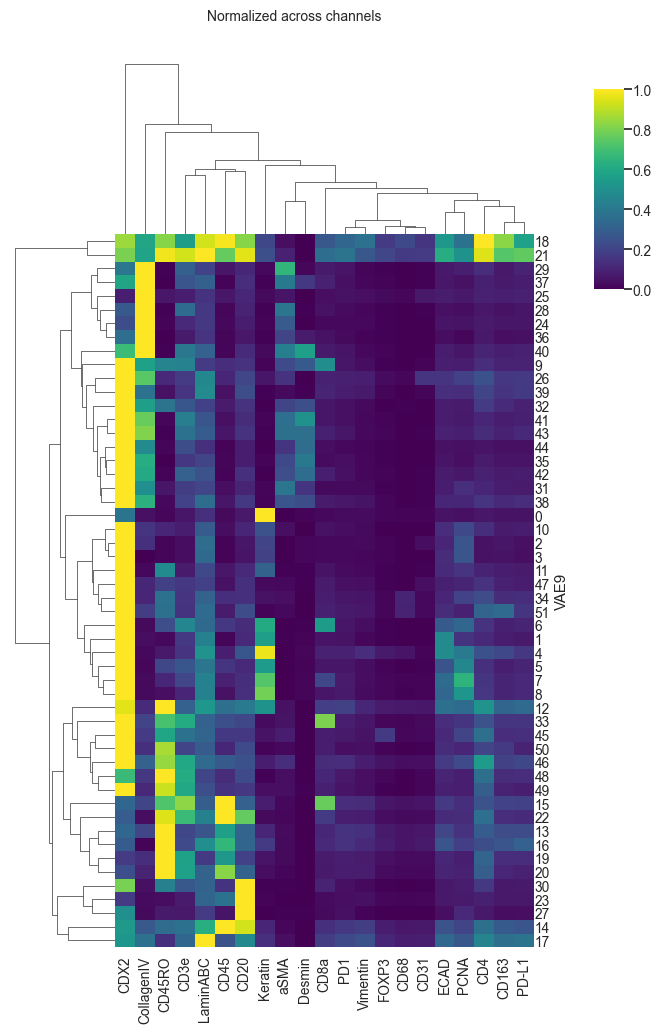


Working on VAE20 rescale is False...


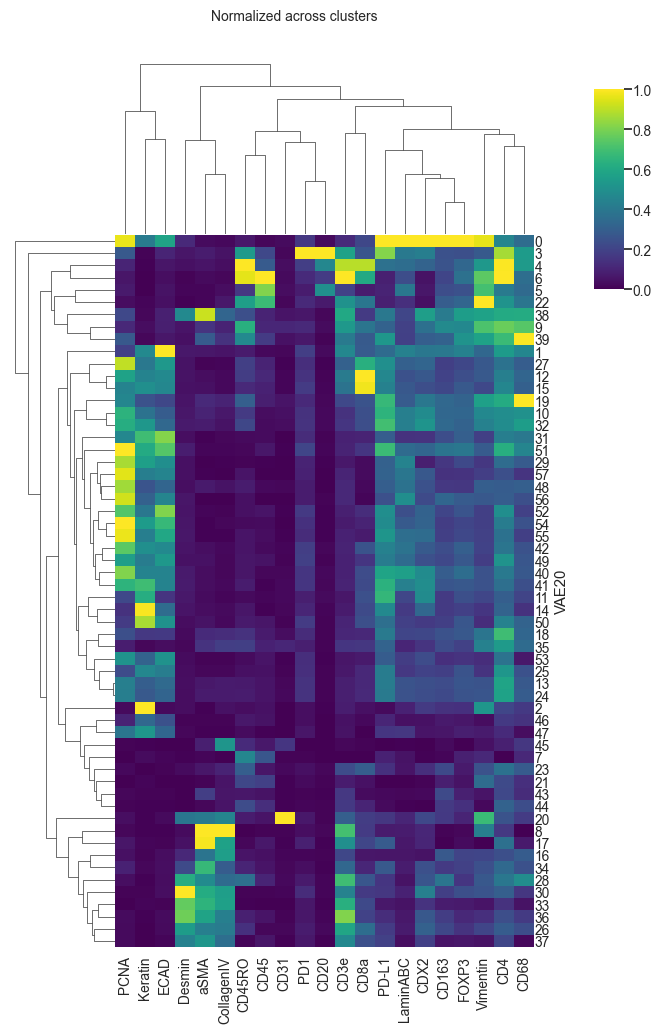

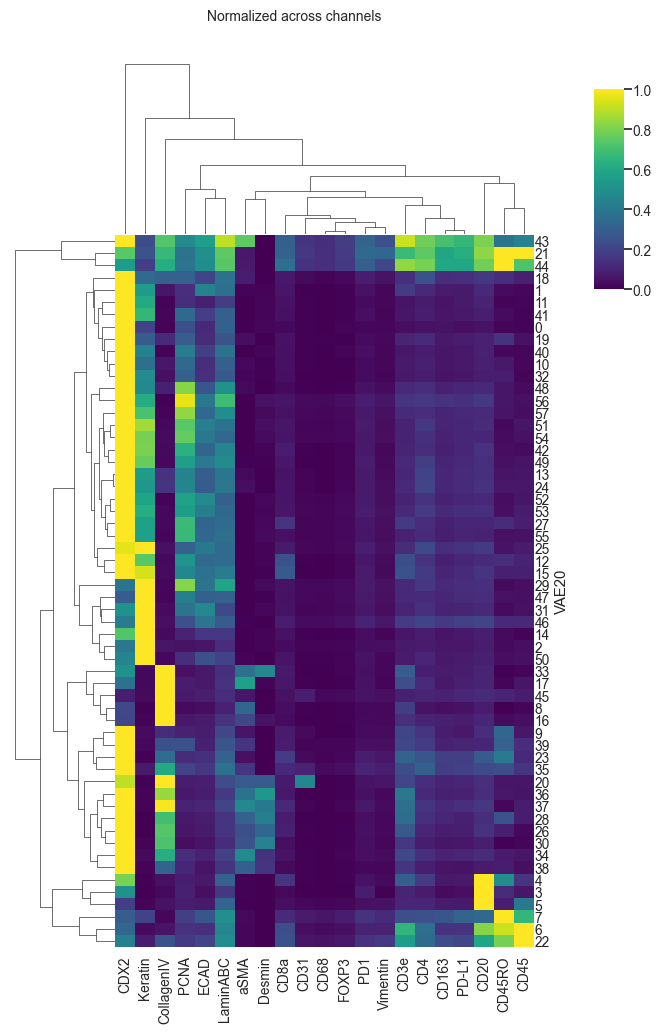

In [5]:
# Compute and plot patch-based average intensities for VAE20 clusters
markers = {
    0: 'CD3e', 1: 'CD45RO', 2: 'Keratin', 3: 'aSMA', 4: 'CD4', 5: 'CD45',
    6: 'PD1', 7: 'CD20', 8: 'CD68', 9: 'CD8a', 10: 'CD163', 11: 'FOXP3',
    12: 'PD-L1', 13: 'ECAD', 14: 'Vimentin', 15: 'CDX2', 16: 'LaminABC',
    17: 'Desmin', 18: 'CD31', 19: 'PCNA', 20: 'CollagenIV'
}

for rescale in [True, False]:
    for name, root in zip(
        ['VAE9-VAE20', 'VAE9', 'VAE20'],
        [
            os.path.join(os.getcwd(), 'input/VAE9/6_latent_space_LD184'),
            os.path.join(os.getcwd(), 'input/VAE9/6_latent_space_LD184'),
            os.path.join(os.getcwd(), 'input/VAE20/6_latent_space_LD850')
        ]
    ):

        print(f'Working on {name} rescale is {rescale}...')

        # Read combined training, validation, and test thumbnails
        combo_dir = os.path.join(root, 'combined_zarr')
        X_combo = zarr.open(combo_dir)
        X_combo = transposeZarr(X_combo)
        
        clustermap_input = pd.DataFrame(
            index=range(X_combo.shape[0]), columns=[i for i in markers.values()]
        )
        
        if rescale:
            # Perform 0-1 normalization for each channel within each image patch
            mins = X_combo.min(axis=(1, 2), keepdims=True)
            maxs = X_combo.max(axis=(1, 2), keepdims=True)
            X_combo = (X_combo - mins) / ((maxs - mins) + 0.00000000000001)  # avoid divide by zero errors in images whose min and max are the same
            means = X_combo.mean(axis=(1, 2))
        else:
            means = X_combo.mean(axis=(1, 2))

        clustermap_input[:] = means
        clustermap_input = clustermap_input.astype('float32')

        clustermap_input[name] = main[name]
        
        linewidth = 0.0
        if name == 'VAE9-VAE20':
            
            clustermap_input['vae_tuple'] = main['VAE_Tuples']
            clustermap_input = clustermap_input[
                clustermap_input.index.isin(filt.index)]
            clustermap_input['state'] = filt['state']
            clustermap_input['context'] = filt['context']
            
            sns.set(font_scale=0.3)
            plt.rcParams['xtick.major.pad'] = '0'
            plt.rcParams['ytick.major.pad'] = '0'
            linewidths = 0.0

            # Select high-abundance VAE tuple labels
            label_sizes = clustermap_input.groupby('VAE9-VAE20').size()
            selected_labels = label_sizes.index[label_sizes > 122]
            clustermap_input = clustermap_input[
                clustermap_input['VAE9-VAE20'].isin(selected_labels)
            ]

            # Compute median antibody signals for clusters
            clustermap_input = clustermap_input.groupby(
                [name, 'vae_tuple', 'state', 'context']).median()

            idx = clustermap_input.index
            clustermap_input.index = [
                r"$\bf{" 'L' + str(int(i[0])) + "}$" + ' — ' +
                r"$\bf{" 'S' + i[1].split('_')[0] + ': ' "}$" + i[2] + '; '
                r"$\bf{" 'C' + i[1].split('_')[1] + ': ' "}$" + i[3]
                for i in idx
            ]
        else:
            sns.set(font_scale=0.9)
            # Compute median antibody signals for clusters
            clustermap_input = clustermap_input.groupby(name).median()
            clustermap_input.drop(index=-1, inplace=True)

        for norm, axis in zip(['clusters', 'channels'], [1, 0]):

            g = sns.clustermap(
                clustermap_input, cmap='viridis', standard_scale=axis,
                yticklabels=1, xticklabels=1, linewidths=linewidth,
                linecolor='grey', cbar=True, figsize=(6, 10)
            )

            g.ax_cbar.set_position([1.0, 0.75, 0.05, 0.2])
            g.fig.suptitle(f'Normalized across {norm}', y=1.03, fontsize=10)
            g.ax_heatmap.yaxis.set_tick_params(length=0.05, width=0.01)

            plt.savefig(
                os.path.join(
                    out,
                    f'{name}_by_patch_intensity_norm_{norm}'
                    f'_rescale_{rescale}.pdf'), bbox_inches='tight'
            )
            plt.show()
            plt.close('all')
        print()